In [1]:
import gym
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras import Model
from datetime import datetime as t

In [2]:
def loss(G,actions,yhat):
    selected_action_values = tf.reduce_sum(yhat * tf.one_hot(actions, K),axis=1)
    cost = tf.reduce_sum(tf.square(G - selected_action_values))
    return cost

In [3]:
@tf.function
def train_step(model,opt , inputs, G , actions):
    with tf.GradientTape() as tape:
        yhat = model(inputs, training=True)
        loss_value = loss(G,actions,yhat)
    grads = tape.gradient(loss_value, model.trainable_weights)
    opt.apply_gradients(zip(grads, model.trainable_weights))
    return loss_value

In [4]:
def create_model(D):
    input_ = Input(shape=(D))
    x = Dense(units=200,activation='tanh')(input_)
    x = Dense(units=200,activation='tanh')(x)
    yhat =  Dense(units=K,activation=None)(x)
    model = Model(inputs=input_,outputs=yhat)
    return model

In [5]:
def sample_action(model,x,eps):
    if np.random.random() < eps:
        return np.random.choice(K)
    else:
        x = np.atleast_2d(x).astype('float32')
        return np.argmax(model(x).numpy()[0])


In [6]:
class replay_buffer:
    def __init__(self,gamma=0.99, max_experiences=10000, min_experiences=100,batch_size = 32):
        # create replay memory
        self.experience = {'s': [], 'a': [], 'r': [], 's2': [], 'done': []}
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences
        self.gamma = gamma
        self.batch_size = batch_size


In [7]:
def add_experience(rb, s, a, r, s2, done):
    if len(rb.experience['s']) >= rb.max_experiences:
        rb.experience['s'].pop(0)
        rb.experience['a'].pop(0)
        rb.experience['r'].pop(0)
        rb.experience['s2'].pop(0)
        rb.experience['done'].pop(0)
    rb.experience['s'].append(s)
    rb.experience['a'].append(a)
    rb.experience['r'].append(r)
    rb.experience['s2'].append(s2)
    rb.experience['done'].append(done)

In [8]:
def train(model,target_network,rb,opt):
    if len(rb.experience['s']) < rb.min_experiences:
        return # not enough experiences
    # replay random batch of previous experiences
    idx = np.random.choice(len(rb.experience['s']),size=rb.batch_size, replace=False)
    states = [rb.experience['s'][i] for i in idx]
    actions = [rb.experience['a'][i] for i in idx]
    rewards = [rb.experience['r'][i] for i in idx]
    next_states = [rb.experience['s2'][i] for i in idx]
    dones = [rb.experience['done'][i] for i in idx]
    next_Q = np.max(target_network(np.array(next_states).astype('float32')), axis=1)
    G = [r + rb.gamma*next_q if not done else r for r, next_q, done in zip(rewards, next_Q, dones)]
    states = np.array(states).astype('float32')
    G = np.array(G).astype('float32')
    actions = np.array(actions).astype('int32')
    train_step(model,opt,states,G,actions)

In [9]:
def copy_weights(from_,to):
    weights = [w.numpy() for w in from_.weights]
    to.set_weights(weights)


In [10]:
def play_one(env,model,tmodel,eps,gamma,copy_period,opt,rb):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    while not done and iters < 2000:
        
        action = sample_action(model,observation,eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        
        totalreward += reward
        if done:
            reward = -200
            
        # update the model
        add_experience(rb,prev_observation, action, reward, observation, done)
        train(model,tmodel,rb,opt)

        iters += 1

        if iters % copy_period == 0:
            copy_weights(model,tmodel)

    return totalreward

        

        

In [11]:
def plot_running_avg(totalrewards):
    # average results over 100 episodes
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0,t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title('Running Average')
    plt.show()

In [12]:
env = gym.make('CartPole-v0')
gamma = 0.99
copy_period = 25
batch_size = 32

D = len(env.observation_space.sample())
K = env.action_space.n

monitor = False
monitor_dir = 'videos/'
if 'monitor' in sys.argv:
    env = wrappers.Monitor(env, monitor_dir)


episode: 0 total reward: 12.0 eps: 1.0 avg reward (last 100): 12.0
episode: 100 total reward: 200.0 eps: 0.09950371902099892 avg reward (last 100): 87.4950495049505
episode: 200 total reward: 200.0 eps: 0.07053456158585983 avg reward (last 100): 165.32673267326732
episode: 300 total reward: 39.0 eps: 0.0576390417704235 avg reward (last 100): 158.93069306930693
episode: 400 total reward: 53.0 eps: 0.04993761694389223 avg reward (last 100): 145.26732673267327
avg reward for last 100 episodes: 140.36
total steps: 69803.0


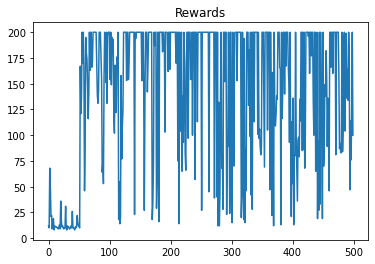

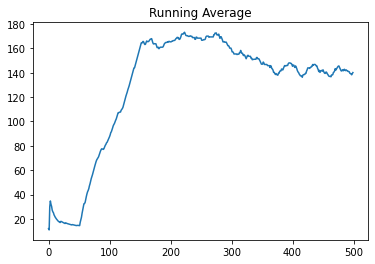

In [13]:
model = create_model(D)
tmodel = create_model(D)
rb = replay_buffer()
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)


N = 500
totalrewards = np.empty(N)
costs = np.empty(N)
for n in range(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(env, model, tmodel, eps, gamma, copy_period,opt,rb)
    totalrewards[n] = totalreward
    if n % 100 == 0:
        print("episode:", n, "total reward:", totalreward, "eps:", eps, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())

print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
print("total steps:", totalrewards.sum())

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()
plot_running_avg(totalrewards)
